# Making the Most of your Colab Subscription



In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')
'''
# Specify the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/real data.zip'

# Specify the extraction destination
extract_path = '/content/drive/MyDrive/'

# Create the extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# List extracted files
print("\nExtracted files:")
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))
      '''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\n# Specify the path to your zip file in Google Drive\nzip_path = \'/content/drive/MyDrive/real data.zip\'\n\n# Specify the extraction destination\nextract_path = \'/content/drive/MyDrive/\'\n\n# Create the extraction folder if it doesn\'t exist\nos.makedirs(extract_path, exist_ok=True)\n\n# Extract the zip file\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\nprint(f"Files extracted to: {extract_path}")\n\n# List extracted files\nprint("\nExtracted files:")\nfor root, dirs, files in os.walk(extract_path):\n    for file in files:\n        print(os.path.join(root, file))\n      '

## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 12 08:09:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#!pip install torch torchvision
#!pip install timm
#!pip install pillow
#!pip install -U scikit-learn scipy matplotlib
#!pip install seaborn
#!pip install ipywidgets

In [ ]:
import torch
import torchvision
import timm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
# Define data directories
data_dir = '/content/drive/MyDrive/real data/source2'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validate')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# EDA and Data Visualization
def plot_class_distribution(data_dir):
    classes = os.listdir(data_dir)
    class_sizes = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]
    plt.figure(figsize=(10, 6))
    plt.bar(classes, class_sizes)
    plt.title(f'Class Distribution in {os.path.basename(data_dir)} Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

In [ ]:
def plot_image_sizes(data_dir):
    widths = []
    heights = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                with Image.open(os.path.join(root, file)) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_image_channels(data_dir):
    channels = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                with Image.open(os.path.join(root, file)) as img:
                    channels.append(len(img.getbands()))

    plt.figure(figsize=(8, 6))
    plt.hist(channels, bins=range(min(channels), max(channels) + 2, 1))
    plt.title('Image Channel Distribution')
    plt.xlabel('Number of Channels')
    plt.ylabel('Count')
    plt.show()

In [ ]:
def plot_sample_images(data_dir, num_samples=5):
    classes = os.listdir(data_dir)
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5 * len(classes)))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        images = os.listdir(class_dir)
        samples = np.random.choice(images, num_samples, replace=False)

        for j, sample in enumerate(samples):
            img = Image.open(os.path.join(class_dir, sample))
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_ylabel(cls)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_pixel_intensity_distribution(data_dir):
    intensities = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                with Image.open(os.path.join(root, file)) as img:
                    img_array = np.array(img)
                    intensities.extend(img_array.flatten())

    plt.figure(figsize=(10, 6))
    plt.hist(intensities, bins=256, range=(0, 255), density=True)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.show()

In [ ]:
# Perform EDA
print("Performing Exploratory Data Analysis...")

Performing Exploratory Data Analysis...


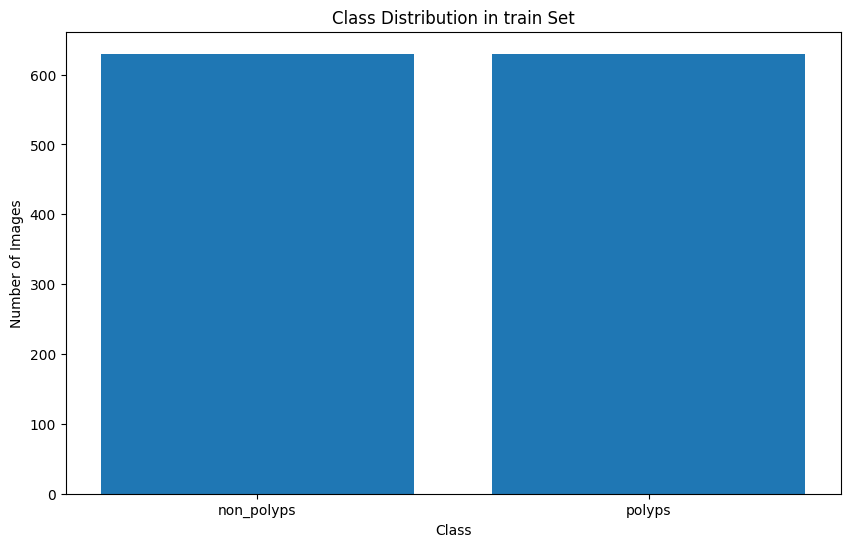

In [ ]:
plot_class_distribution(train_dir)

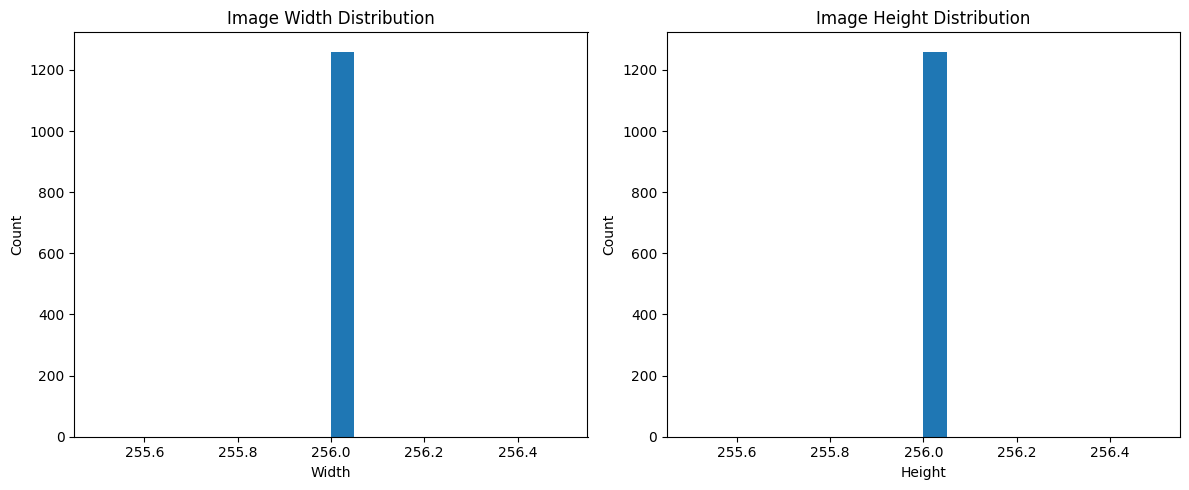

In [ ]:
plot_image_sizes(train_dir)

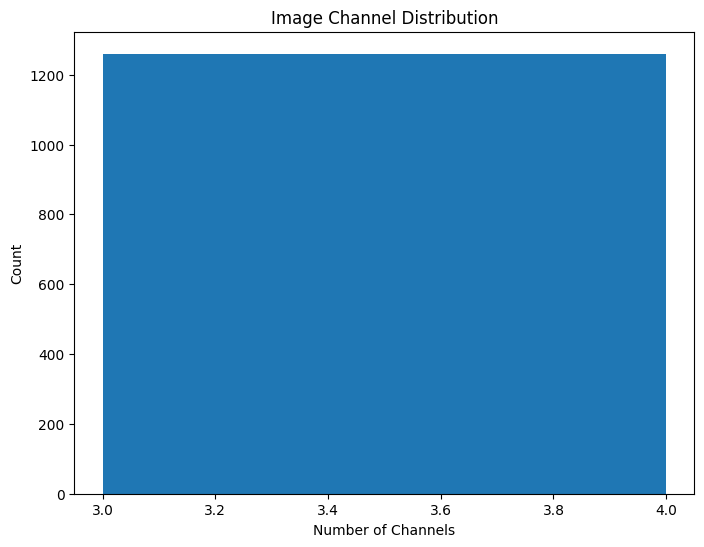

In [ ]:
plot_image_channels(train_dir)

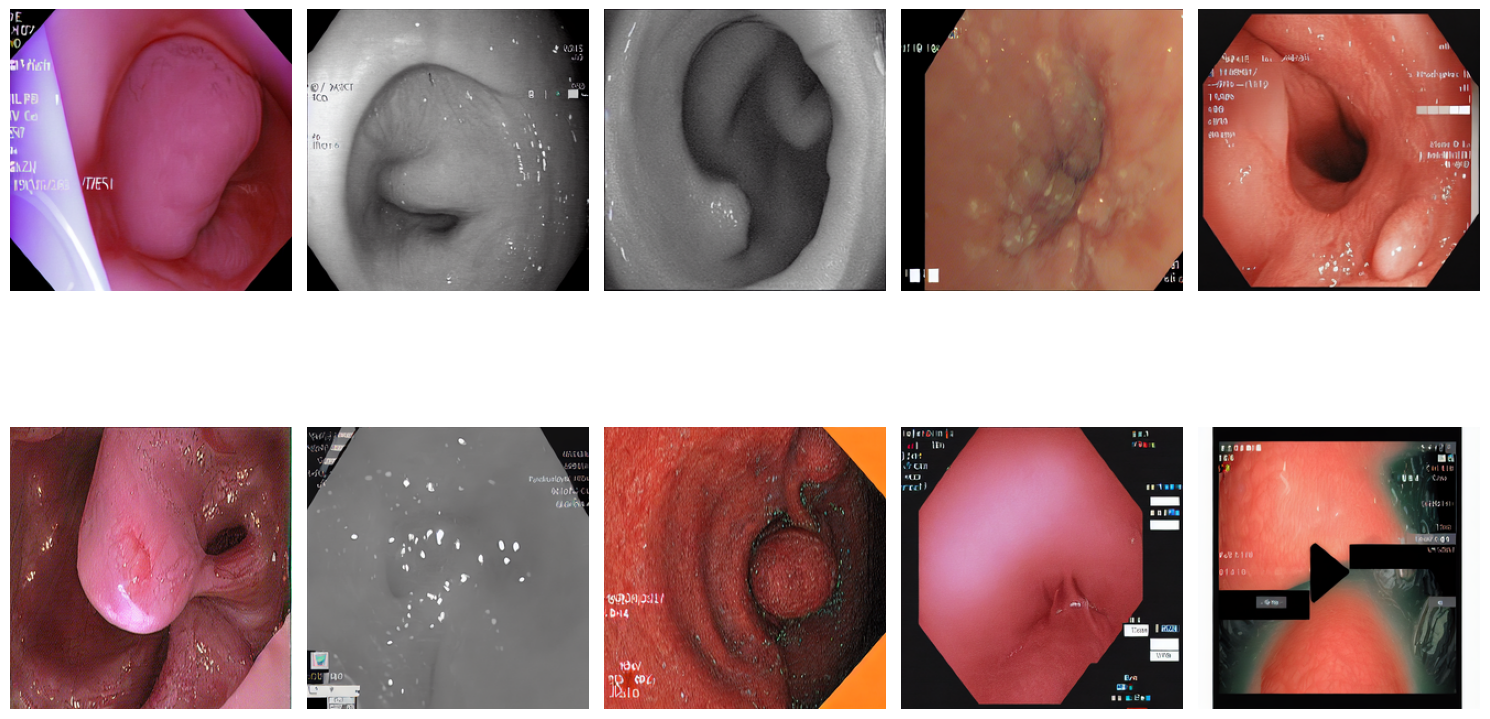

In [ ]:
plot_sample_images(train_dir)

In [ ]:
# Define transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define models
models = {
    'ViT': timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2),
    'BiT': timm.create_model('resnetv2_101x1_bit.goog_in21k_ft_in1k', pretrained=True, num_classes=2),
    'FixResNeXt': timm.create_model('resnext101_32x8d', pretrained=True, num_classes=2),
    'DeiT': timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=2),
    'EfficientNet': timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    return avg_loss, all_labels, all_preds

In [ ]:
def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    try:
        auc = roc_auc_score(true_labels, predictions)
    except ValueError:
        auc = float('nan')
    return accuracy, precision, recall, f1, auc

In [ ]:
def plot_roc(true_labels, predictions, title):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{total_loss/(i+1):.4f}'})

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on validation set
        val_loss, _, _ = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            early_stop = True
            break

    # Load best model
    model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))
    return model, train_losses, val_losses, early_stop

In [ ]:
def plot_combined_roc(all_labels, all_predictions, all_model_names, title):
    plt.figure(figsize=(10, 8))
    for labels, predictions, model_name in zip(all_labels, all_predictions, all_model_names):
        fpr, tpr, _ = roc_curve(labels, predictions)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Combined ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plot_loss_curves(train_losses, val_losses, title, early_stop):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {title}')
    if early_stop:
        plt.axvline(x=len(val_losses)-1, color='r', linestyle='--', label='Early Stopping')
    plt.legend()
    plt.show()

In [ ]:
# Main execution
all_train_labels = []
all_train_predictions = []
all_val_labels = []
all_val_predictions = []
all_test_labels = []
all_test_predictions = []
model_names = []

In [ ]:
for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}")
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    trained_model, train_losses, val_losses, early_stop = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

    print("\nFinal Evaluation:")
    # Evaluate on training set
    train_loss, train_labels, train_preds = evaluate_model(trained_model, train_loader)
    train_accuracy, train_precision, train_recall, train_f1, train_auc = calculate_metrics(train_labels, train_preds)
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")

    # Evaluate on validation set
    val_loss, val_labels, val_preds = evaluate_model(trained_model, val_loader)
    val_accuracy, val_precision, val_recall, val_f1, val_auc = calculate_metrics(val_labels, val_preds)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    # Evaluate on test set
    test_loss, test_labels, test_preds = evaluate_model(trained_model, test_loader)


Training and evaluating ViT


Epoch 1/10: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s, Loss=1.6278]


Epoch 1/10 - Train Loss: 1.6278, Val Loss: 0.6891


Epoch 2/10: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s, Loss=0.7121]


Epoch 2/10 - Train Loss: 0.7121, Val Loss: 0.7573


Epoch 3/10: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s, Loss=0.9081]


Epoch 3/10 - Train Loss: 0.9081, Val Loss: 1.1300


Epoch 4/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.8450]


Epoch 4/10 - Train Loss: 0.8450, Val Loss: 0.7995


Epoch 5/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.7960]


Epoch 5/10 - Train Loss: 0.7960, Val Loss: 0.7035


Epoch 6/10: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s, Loss=0.6972]


Epoch 6/10 - Train Loss: 0.6972, Val Loss: 0.6741


Epoch 7/10: 100%|██████████| 40/40 [00:26<00:00,  1.53it/s, Loss=0.6894]


Epoch 7/10 - Train Loss: 0.6894, Val Loss: 0.6744


Epoch 8/10: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s, Loss=0.6860]


Epoch 8/10 - Train Loss: 0.6860, Val Loss: 0.6691


Epoch 9/10: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s, Loss=0.6848]


Epoch 9/10 - Train Loss: 0.6848, Val Loss: 0.6822


Epoch 10/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.6842]


Epoch 10/10 - Train Loss: 0.6842, Val Loss: 0.6766


<ipython-input-24-6cea04f1ad80>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))



Final Evaluation:
Training - Loss: 0.6813, Accuracy: 0.61%, Precision: 0.6146, Recall: 0.6087, F1: 0.6036, AUC: 0.6087
Validation - Loss: 0.6691, Accuracy: 0.70%, Precision: 0.7547, Recall: 0.6978, F1: 0.6799, AUC: 0.6978

Training and evaluating BiT


Epoch 1/10: 100%|██████████| 40/40 [00:20<00:00,  1.96it/s, Loss=1.2739]


Epoch 1/10 - Train Loss: 1.2739, Val Loss: 0.6942


Epoch 2/10: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s, Loss=0.6976]


Epoch 2/10 - Train Loss: 0.6976, Val Loss: 0.6927


Epoch 3/10: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s, Loss=0.7026]


Epoch 3/10 - Train Loss: 0.7026, Val Loss: 0.6880


Epoch 4/10: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s, Loss=0.7023]


Epoch 4/10 - Train Loss: 0.7023, Val Loss: 0.7036


Epoch 5/10: 100%|██████████| 40/40 [00:19<00:00,  2.00it/s, Loss=0.7006]


Epoch 5/10 - Train Loss: 0.7006, Val Loss: 0.6756


Epoch 6/10: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s, Loss=0.6826]


Epoch 6/10 - Train Loss: 0.6826, Val Loss: 0.6828


Epoch 7/10: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s, Loss=0.6896]


Epoch 7/10 - Train Loss: 0.6896, Val Loss: 0.7014


Epoch 8/10: 100%|██████████| 40/40 [00:20<00:00,  2.00it/s, Loss=0.7136]


Epoch 8/10 - Train Loss: 0.7136, Val Loss: 0.6869


Epoch 9/10: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s, Loss=0.6750]


Epoch 9/10 - Train Loss: 0.6750, Val Loss: 0.6406


Epoch 10/10: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s, Loss=0.6712]


Epoch 10/10 - Train Loss: 0.6712, Val Loss: 0.6376


<ipython-input-24-6cea04f1ad80>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))



Final Evaluation:
Training - Loss: 0.6677, Accuracy: 0.59%, Precision: 0.6498, Recall: 0.5857, F1: 0.5361, AUC: 0.5857
Validation - Loss: 0.6376, Accuracy: 0.64%, Precision: 0.7564, Recall: 0.6374, F1: 0.5898, AUC: 0.6374

Training and evaluating FixResNeXt


Epoch 1/10: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s, Loss=0.8295]


Epoch 1/10 - Train Loss: 0.8295, Val Loss: 1.4516


Epoch 2/10: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s, Loss=0.6710]


Epoch 2/10 - Train Loss: 0.6710, Val Loss: 0.6503


Epoch 3/10: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s, Loss=0.6711]


Epoch 3/10 - Train Loss: 0.6711, Val Loss: 0.6230


Epoch 4/10: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s, Loss=0.6660]


Epoch 4/10 - Train Loss: 0.6660, Val Loss: 0.6428


Epoch 5/10: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s, Loss=0.6594]


Epoch 5/10 - Train Loss: 0.6594, Val Loss: 0.6162


Epoch 6/10: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s, Loss=0.6601]


Epoch 6/10 - Train Loss: 0.6601, Val Loss: 0.6218


Epoch 7/10: 100%|██████████| 40/40 [00:21<00:00,  1.84it/s, Loss=0.6760]


Epoch 7/10 - Train Loss: 0.6760, Val Loss: 0.6259


Epoch 8/10: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s, Loss=0.6509]


Epoch 8/10 - Train Loss: 0.6509, Val Loss: 0.6163


Epoch 9/10: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s, Loss=0.6261]


Epoch 9/10 - Train Loss: 0.6261, Val Loss: 0.5804


Epoch 10/10: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s, Loss=0.6187]


Epoch 10/10 - Train Loss: 0.6187, Val Loss: 0.6230


<ipython-input-24-6cea04f1ad80>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))



Final Evaluation:
Training - Loss: 0.6111, Accuracy: 0.66%, Precision: 0.6649, Recall: 0.6643, F1: 0.6640, AUC: 0.6643
Validation - Loss: 0.5804, Accuracy: 0.71%, Precision: 0.7100, Recall: 0.7088, F1: 0.7084, AUC: 0.7088

Training and evaluating DeiT


Epoch 1/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.8149]


Epoch 1/10 - Train Loss: 0.8149, Val Loss: 0.6802


Epoch 2/10: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s, Loss=0.7068]


Epoch 2/10 - Train Loss: 0.7068, Val Loss: 0.6944


Epoch 3/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.6864]


Epoch 3/10 - Train Loss: 0.6864, Val Loss: 0.6264


Epoch 4/10: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s, Loss=0.6681]


Epoch 4/10 - Train Loss: 0.6681, Val Loss: 0.5990


Epoch 5/10: 100%|██████████| 40/40 [00:26<00:00,  1.54it/s, Loss=0.6720]


Epoch 5/10 - Train Loss: 0.6720, Val Loss: 0.6282


Epoch 6/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.6706]


Epoch 6/10 - Train Loss: 0.6706, Val Loss: 0.6549


Epoch 7/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.6763]


Epoch 7/10 - Train Loss: 0.6763, Val Loss: 0.6717


Epoch 8/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.6750]


Epoch 8/10 - Train Loss: 0.6750, Val Loss: 0.6288


Epoch 9/10: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s, Loss=0.6552]


Epoch 9/10 - Train Loss: 0.6552, Val Loss: 0.6132
Early stopping triggered after 9 epochs

Final Evaluation:


<ipython-input-24-6cea04f1ad80>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))


Training - Loss: 0.6656, Accuracy: 0.59%, Precision: 0.5933, Recall: 0.5929, F1: 0.5924, AUC: 0.5929
Validation - Loss: 0.5990, Accuracy: 0.70%, Precision: 0.7159, Recall: 0.7033, F1: 0.6989, AUC: 0.7033

Training and evaluating EfficientNet


Epoch 1/10: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s, Loss=3.2030]


Epoch 1/10 - Train Loss: 3.2030, Val Loss: 2.5385


Epoch 2/10: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s, Loss=1.7762]


Epoch 2/10 - Train Loss: 1.7762, Val Loss: 1.1688


Epoch 3/10: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s, Loss=1.2816]


Epoch 3/10 - Train Loss: 1.2816, Val Loss: 0.8624


Epoch 4/10: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s, Loss=0.7484]


Epoch 4/10 - Train Loss: 0.7484, Val Loss: 0.8055


Epoch 5/10: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s, Loss=0.5635]


Epoch 5/10 - Train Loss: 0.5635, Val Loss: 0.6212


Epoch 6/10: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s, Loss=0.5113]


Epoch 6/10 - Train Loss: 0.5113, Val Loss: 0.6149


Epoch 7/10: 100%|██████████| 40/40 [00:18<00:00,  2.17it/s, Loss=0.4560]


Epoch 7/10 - Train Loss: 0.4560, Val Loss: 0.5133


Epoch 8/10: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s, Loss=0.4793]


Epoch 8/10 - Train Loss: 0.4793, Val Loss: 0.5622


Epoch 9/10: 100%|██████████| 40/40 [00:18<00:00,  2.17it/s, Loss=0.3991]


Epoch 9/10 - Train Loss: 0.3991, Val Loss: 0.7836


Epoch 10/10: 100%|██████████| 40/40 [00:18<00:00,  2.17it/s, Loss=0.4500]


Epoch 10/10 - Train Loss: 0.4500, Val Loss: 0.6042

Final Evaluation:


<ipython-input-24-6cea04f1ad80>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))


Training - Loss: 0.4334, Accuracy: 0.80%, Precision: 0.8094, Recall: 0.8000, F1: 0.7985, AUC: 0.8000
Validation - Loss: 0.5133, Accuracy: 0.79%, Precision: 0.7935, Recall: 0.7912, F1: 0.7908, AUC: 0.7912
